In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from core.architecture.experiment.TimeSeriesClassifier import TimeSeriesClassifier
from core.architecture.postprocessing.Analyzer import PerformanceAnalyzer
from core.architecture.preprocessing.DatasetLoader import DataLoader
from core.models.spectral.SSARunner import SSARunner
from core.models.statistical.QuantileRunner import StatsRunner
from sklearn.metrics import classification_report

Create support fucntions for visualisation and result of experiment analysis

In [59]:
def compare_results(sota_dict, current_results):
    counter = 0
    for SOTA_model in sota_dict.keys():
        diff = current_results - sota_dict[SOTA_model]
        if diff > 0:
            print(f'FEDOT_TSC better than {SOTA_model} by {round(abs(diff*100))} %')
            counter += 1
    print(f'FEDOT_TSC better than - {round((counter/13)*100)} % SOTA models')

def plot_sample_by_class(samples, labels, mode: str = None):
    if mode is None:
        df = samples
    else:
        df = pd.DataFrame([x[mode].values for x in samples])
    df = df.set_index(labels)
    temp_df = pd.DataFrame()
    for label in np.unique(labels):
        temp_df[f'Meadian_TS. Class -{label}'] = df[df.index == label].median()
    temp_df.plot(figsize=(15, 10))
    plt.show()

def get_results(model, features, target):
    labels = model.predict(test_features=features)
    probs = model.predict_proba(test_features=features)
    metrics = PerformanceAnalyzer().calculate_metrics(target=target,
                                                      predicted_labels=labels['label'],
                                                      predicted_probs=probs['class_probability'])

    return metrics

The FORTE satellite detects transient electromagnetic events associated with lightning using a suite of optical
and radio-frequency (RF) instruments. 
The seven classes:
1. CG Positive: Initial Return Stroke A positive charge is lowered from a cloud to the ground.
The characteristic feature of this type of event in the power density time series is a sharp turn-on of radiation,
followed by a few hundreds of microseconds of noise.

2. IR Negative: Initial Return Stroke A negative charge is lowered from a cloud to ground.
The power waveform slowly ramps up to a level known as an attachment point, where a large surge current causes
the VHF power to 'spike'. This attachment is followed by an exponentially shaped decline in the waveform.
3. SR Subsequent Negative Return Stroke A negative charge is lowered from a cloud to ground. As the name implies,
subsequent return strokes come after initial return strokes. Note that subsequent positive return strokes don't exist.

4. I Impulsive Event Typically an intra-cloud event characterized by a sudden peak in the waveform.

5. I2 Impulsive Event Pair Another intra-cloud event characterized by sudden peaks in the waveform that come in closely
separated pairs. These are also called TIPPs (Trans-Ionospheric Pulse Pairs).

6. KM Gradual Intra-Cloud Stroke An intra-cloud event which increases in power more gradually than an impulsive event.

7. Off-record 800 microseconds was not enough to fully capture the lightning event.

Initialize and visualise data

In [51]:
dataset_name = 'Lightning7'
train, test = DataLoader(dataset_name).load_data()
train_target = train[1]
test_target = test[1]


2022-12-20 17:22:37 - INFO - Reading Lightning7 data locally


Let's plot "median time series representation" of each class.

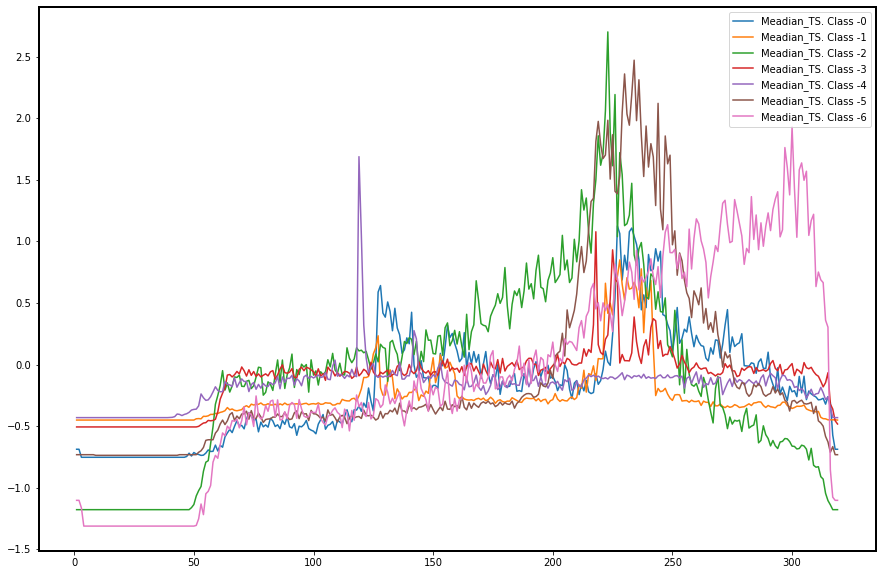

In [4]:
plot_sample_by_class(train[0], train_target)

Create TSC (Time Series Classification) model

In [5]:
basic_ts_clf_class = TimeSeriesClassifier(model_hyperparams={
        'problem': 'classification',
        'seed': 42,
        'timeout': 1,
        'max_depth': 4,
        'max_arity': 2,
        'cv_folds': 2,
        'logging_level': 10,
        'n_jobs': 2
    })

As a baseline, we will use a model based on statistical features of time series.
We will not use any additional transformations such as smoothing or sliding windows.

In [6]:
quantile_model_basic = StatsRunner(window_mode=False)
train_feats_baseline = quantile_model_basic.get_features(train[0], dataset_name)
test_feats_baseline = quantile_model_basic.get_features(test[0], dataset_name)

2022-12-20 16:45:55 - INFO - Number of TS to be processed: 70
2022-12-20 16:45:55 - INFO - Time spent on feature generation - 0.1 sec
2022-12-20 16:45:55 - INFO - Number of TS to be processed: 73
2022-12-20 16:45:56 - INFO - Time spent on feature generation - 0.11 sec


As a more complex model, we will use a model based on spectral features of time series.
An advanced version of this model allows you to reduce the dimension
of the feature space by grouping the PCT (principal component trajectory) among themselves.

In [7]:
spectral_model_basic = SSARunner(window_mode=False,
                                     window_sizes={dataset_name: [30]},
                                     spectral_hyperparams={'combine_eigenvectors': False,
                                                           'correlation_level': 0.8})
train_feats_spectral_basic = spectral_model_basic.get_features(train[0], dataset_name)
test_feats_spectral_basic = spectral_model_basic.get_features(test[0], dataset_name)
train_eigenvectors_spectral_basic = spectral_model_basic.eigenvectors_list_train

2022-12-20 16:45:56 - INFO - Generate features for window length - 30
2022-12-20 16:45:56 - INFO - Number of processes: 4
Feature Generation. TS processed: 100%|██████████| 35/35 [00:01<00:00, 18.25 ts/s]
2022-12-20 16:45:58 - INFO - Number of time series processed: 35
2022-12-20 16:45:58 - INFO - Every eigenvector with impact less then 1 % percent was eliminated. 50 % of explained dispersion obtained by first - 4 components.
2022-12-20 16:45:58 - INFO - Number of processes: 4
Feature Generation. TS processed: 100%|██████████| 70/70 [00:01<00:00, 37.76 ts/s]
2022-12-20 16:46:00 - INFO - Number of time series processed: 70
2022-12-20 16:46:00 - INFO - Window length = 30 was chosen
2022-12-20 16:46:00 - INFO - Time spent on feature generation - 4.83 sec
2022-12-20 16:46:00 - INFO - Number of processes: 4
Feature Generation. TS processed: 100%|██████████| 73/73 [00:02<00:00, 34.95 ts/s]
2022-12-20 16:46:03 - INFO - Number of time series processed: 73
2022-12-20 16:46:04 - INFO - Time spen

Let's plot first 3 samples decomposed into PCT

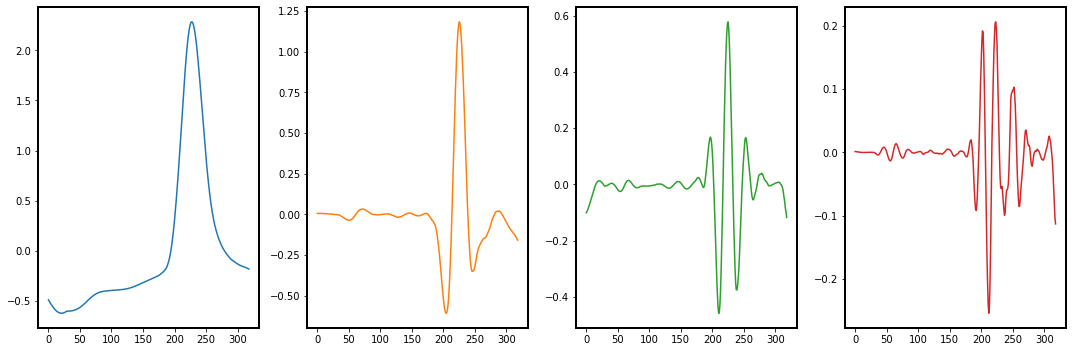

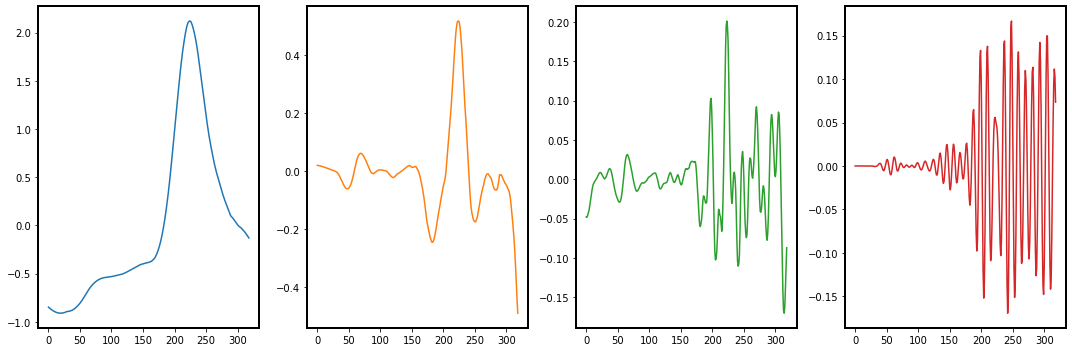

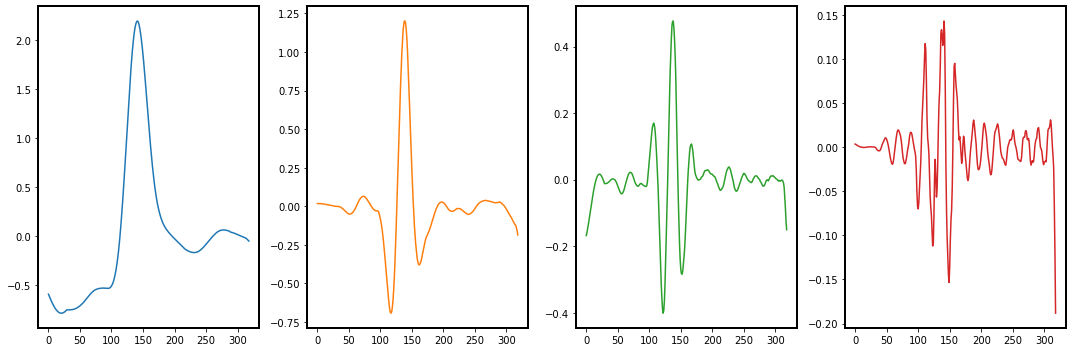

In [8]:
spectral_model_basic.visualise(train_eigenvectors_spectral_basic[:3])

Let's plot median of first PCT

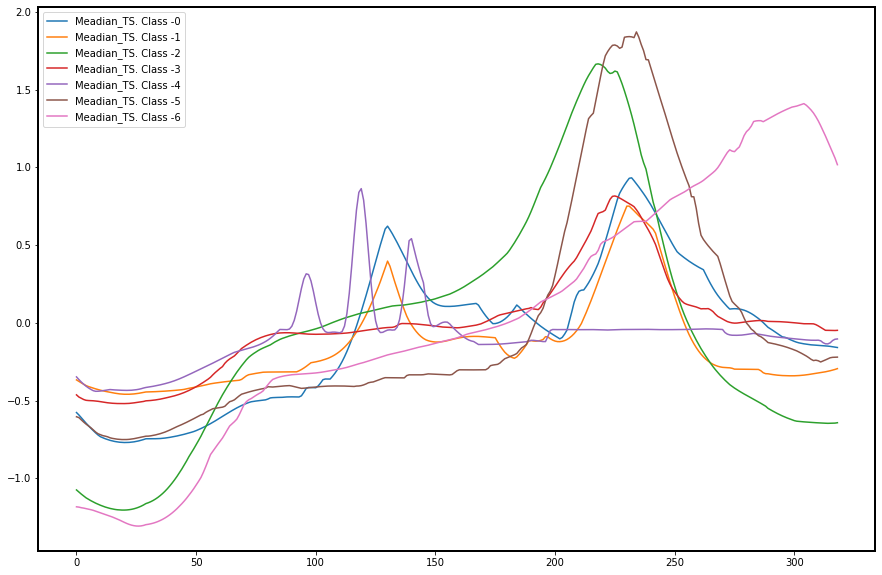

In [9]:
plot_sample_by_class(train_eigenvectors_spectral_basic,train_target,mode='F0')

Let's plot median of second PCT

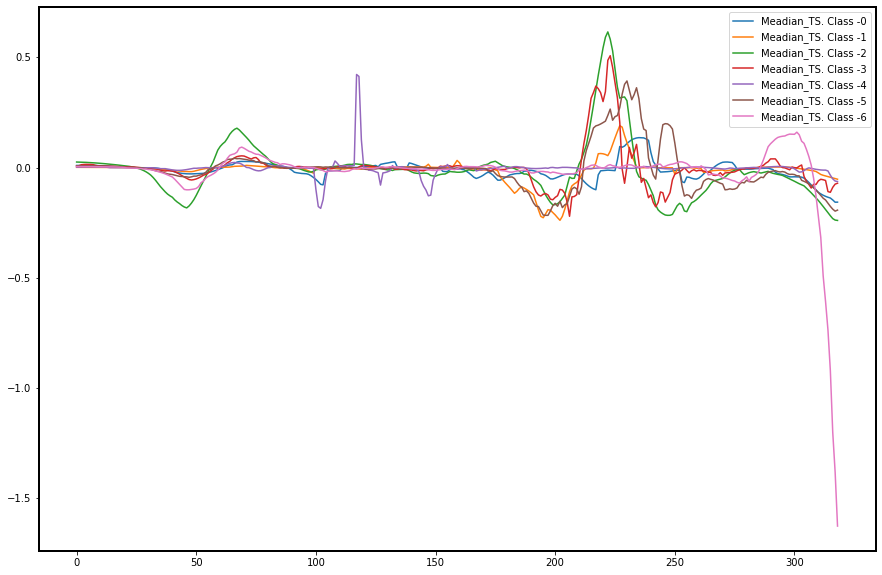

In [10]:
plot_sample_by_class(train_eigenvectors_spectral_basic,train_target,mode='F1')

In [11]:
spectral_model_advanced = SSARunner(window_mode=False,
                                        window_sizes={dataset_name: [30]},
                                        spectral_hyperparams={'combine_eigenvectors': True,
                                                              'correlation_level': 0.8})
train_feats_advanced = spectral_model_advanced.get_features(train[0], dataset_name)
test_feats_advanced = spectral_model_advanced.get_features(test[0], dataset_name)
train_eigenvectors_advanced = spectral_model_advanced.eigenvectors_list_train

2022-12-20 16:46:05 - INFO - Generate features for window length - 30
2022-12-20 16:46:05 - INFO - Number of processes: 4
Feature Generation. TS processed: 100%|██████████| 35/35 [00:01<00:00, 19.32 ts/s]
2022-12-20 16:46:07 - INFO - Number of time series processed: 35
2022-12-20 16:46:07 - INFO - Every eigenvector with impact less then 1 % percent was eliminated. 47 % of explained dispersion obtained by first - 4 components.
2022-12-20 16:46:07 - INFO - Number of processes: 4
Feature Generation. TS processed: 100%|██████████| 70/70 [00:01<00:00, 35.19 ts/s]
2022-12-20 16:46:09 - INFO - Number of time series processed: 70
D:\РАБОТЫ РЕПОЗИТОРИИ\Репозитории\Industiral\IndustrialTS\core\models\spectral\SSARunner.py:260: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

Let's plot first 3 samples decomposed into PCT (principal component trajectory)

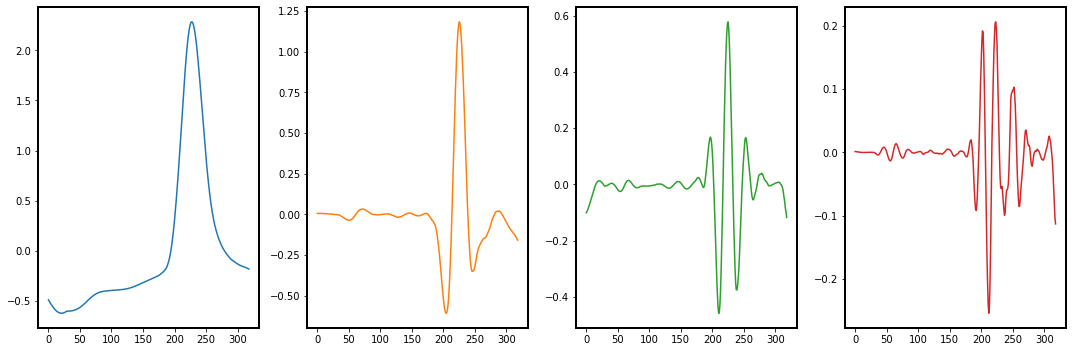

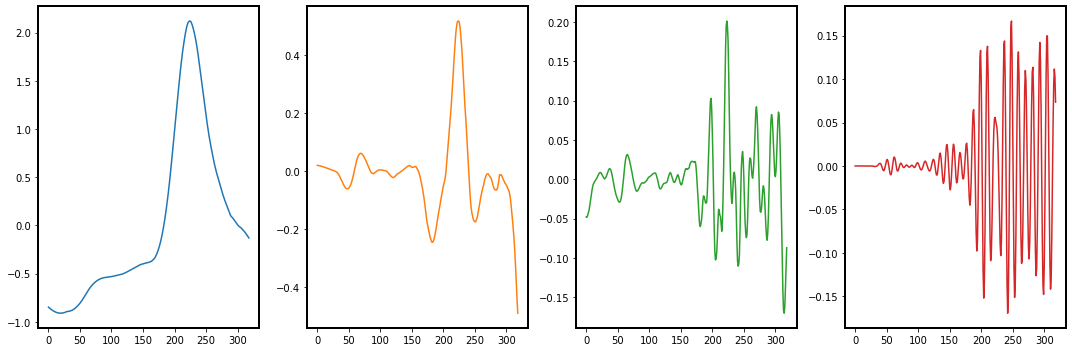

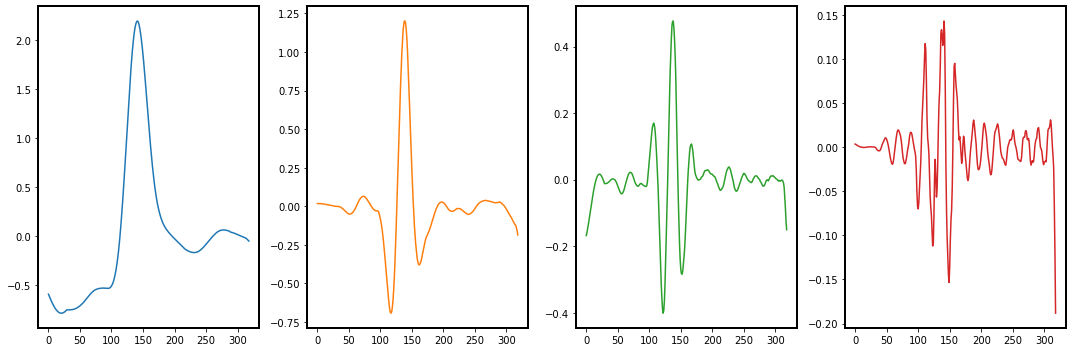

In [12]:
spectral_model_basic.visualise(train_eigenvectors_advanced[:3])

Let's plot median of first PCT

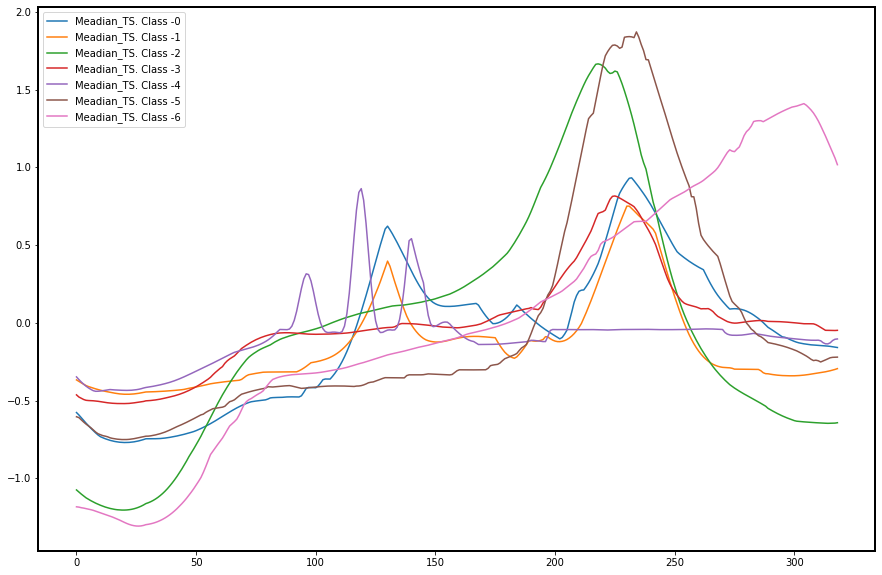

In [13]:
plot_sample_by_class(train_eigenvectors_advanced,train_target,mode=0)

Let's plot median of second PCT

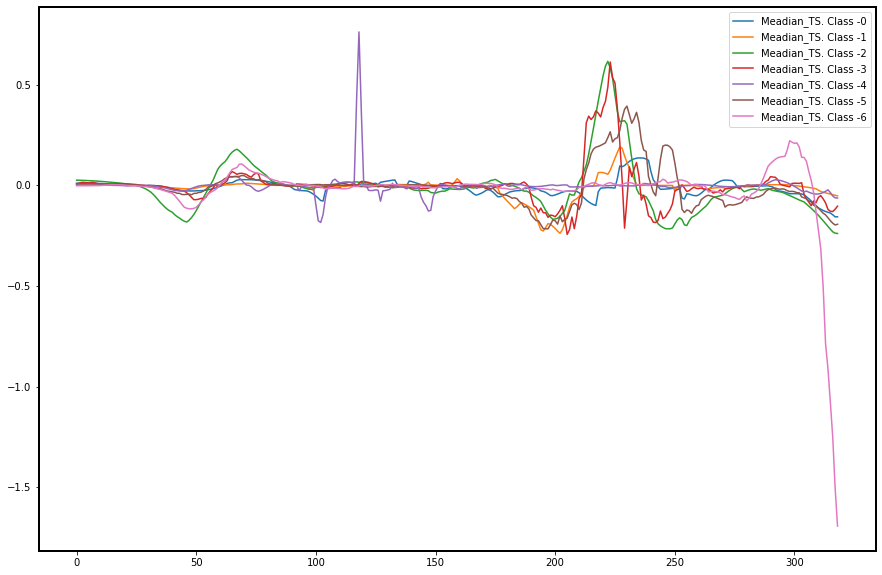

In [14]:
plot_sample_by_class(train_eigenvectors_advanced,train_target,mode=1)

In [35]:
metric_name = 'f1'
models_name = ['Statistical', 'BaseSpectral','AdvancedSpectral']
SOTA_results = [0.788201919, 0.744594487, 0.818165359, 0.794619584, 0.806207058,
                0.7286329, 0.781281546, 0.70060504, 0.680166882,
                0.671386013, 0.71358025, 0.694936093, 0.681765546, 0.62167202]
SOTA_model_names = ['TS-CHIEF',
                    'HIVE-COTE v1.0',
                    'InceptionTime',
                    'ROCKET',
                    'ResNet',
                    'STC'
                    'ProximityForest',
                    'WEASEL',
                    'S-BOSS',
                    'BOSS',
                    'cBOSS',
                    'TSFRISE',
                    'Catch22',
]
SOTA_dict = {k:v for k,v in zip(SOTA_model_names,SOTA_results)}

In [15]:
IndustrialModelBaseline = basic_ts_clf_class.fit(train_features=train_feats_baseline, train_target=train_target)[0]
baseline_results = get_results(basic_ts_clf_class, test_feats_baseline, test_target)
predict_baseline = basic_ts_clf_class.predict(test_feats_baseline)['label']

2022-12-20 16:46:14 - INFO - START TRAINING


2022-12-20 16:46:14,893 - deprecate positional args: graphviz.backend.piping.pipe(['renderer', 'formatter', 'quiet'])
2022-12-20 16:46:14,894 - deprecate positional args: graphviz.backend.rendering.render(['renderer', 'formatter', 'quiet'])
2022-12-20 16:46:14,896 - deprecate positional args: graphviz.backend.unflattening.unflatten(['stagger', 'fanout', 'chain', 'encoding'])
2022-12-20 16:46:14,897 - deprecate positional args: graphviz.backend.viewing.view(['quiet'])
2022-12-20 16:46:14,900 - deprecate positional args: graphviz.quoting.quote(['is_html_string', 'is_valid_id', 'dot_keywords', 'escape_unescaped_quotes'])
2022-12-20 16:46:14,901 - deprecate positional args: graphviz.quoting.a_list(['kwargs', 'attributes'])
2022-12-20 16:46:14,901 - deprecate positional args: graphviz.quoting.attr_list(['kwargs', 'attributes'])
2022-12-20 16:46:14,902 - deprecate positional args: graphviz.dot.Dot.clear(['keep_attrs'])
2022-12-20 16:46:14,902 - deprecate positional args: graphviz.dot.Dot.__i

Generations:   0%|          | 1/10000 [00:00<?, ?gen/s]

2022-12-20 16:46:17,154 - MultiprocessingDispatcher - Number of used CPU's: 2
2022-12-20 16:46:22,517 - EvoGraphOptimizer - Generation num: 1
2022-12-20 16:46:22,518 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: ['get_value_with_penalty=-0.865 ComplexityMetricsEnum.node_num=0.200']
2022-12-20 16:46:22,518 - EvoGraphOptimizer - no improvements for 0 iterations
2022-12-20 16:46:22,519 - EvoGraphOptimizer - spent time: 0.1 min
2022-12-20 16:46:23,195 - MultiprocessingDispatcher - Number of used CPU's: 2
2022-12-20 16:46:29,121 - EvoGraphOptimizer - Generation num: 2
2022-12-20 16:46:29,122 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: ['get_value_with_penalty=-0.894 ComplexityMetricsEnum.node_num=0.200']
2022-12-20 16:46:29,122 - EvoGraphOptimizer - no improvements for 0 iterations
2022-12-20 16:46:29,123 - EvoGraphOptimizer - spent time: 0.2 min
2022-12-20 16:46:29,124 - EvoGraphOptimizer - Next population size: 21; max graph depth: 4
2022-12-2

Generations:   0%|          | 1/10000 [00:34<?, ?gen/s]

2022-12-20 16:46:51,896 - OptimisationTimer - Composition time: 0.579 min
2022-12-20 16:46:51,897 - OptimisationTimer - Algorithm was terminated due to processing time limit
2022-12-20 16:46:51,897 - EvoGraphOptimizer - Generation num: 8
2022-12-20 16:46:51,898 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: ['get_value_with_penalty=-0.894 ComplexityMetricsEnum.node_num=0.200']
2022-12-20 16:46:51,898 - EvoGraphOptimizer - no improvements for 6 iterations
2022-12-20 16:46:51,899 - EvoGraphOptimizer - spent time: 0.6 min
2022-12-20 16:46:51,901 - GPComposer - GP composition finished
2022-12-20 16:46:51,901 - DataSourceSplitter - K-folds cross validation is applied.
2022-12-20 16:46:51,902 - ApiComposer - Hyperparameters tuning started with 0 min. timeout
2022-12-20 16:46:51,903 - PipelineTuner - Hyperparameters optimization start


  0%|          | 0/100000 [00:00<?, ?trial/s, best loss=?]2022-12-20 16:46:52,351 - build_posterior_wrapper took 0.002993 seconds
2022-12-20 16:46:52,352 - TPE using 0 trials
  0%|          | 1/100000 [00:00<10:58:16,  2.53trial/s, best loss: -0.844308]2022-12-20 16:46:52,746 - build_posterior_wrapper took 0.001965 seconds
2022-12-20 16:46:52,747 - TPE using 1/1 trials with best loss -0.844308
  0%|          | 2/100000 [00:00<10:57:16,  2.54trial/s, best loss: -0.8502959999999999]2022-12-20 16:46:53,140 - build_posterior_wrapper took 0.002019 seconds
2022-12-20 16:46:53,141 - TPE using 2/2 trials with best loss -0.850296
  0%|          | 3/100000 [00:01<11:02:16,  2.52trial/s, best loss: -0.862771]          2022-12-20 16:46:53,541 - build_posterior_wrapper took 0.001962 seconds
2022-12-20 16:46:53,542 - TPE using 3/3 trials with best loss -0.862771
  0%|          | 4/100000 [00:01<11:01:58,  2.52trial/s, best loss: -0.862771]2022-12-20 16:46:53,938 - build_posterior_wrapper took 0.0029

In [16]:
baseline_results

{'roc_auc': 0.899,
 'f1': 0.466,
 'precision': 0.561,
 'accuracy': 0.521,
 'logloss': 1.102}

In [62]:
compare_results(sota_dict=SOTA_dict,current_results=baseline_results[metric_name])

FEDOT_TSC better than - 0 % SOTA models


In [17]:
IndustrialModelSpectral = basic_ts_clf_class.fit(train_features=train_feats_spectral_basic, train_target=train_target)[0]
basic_result = get_results(basic_ts_clf_class, test_feats_spectral_basic, test_target)
predict_basic = basic_ts_clf_class.predict(test_feats_spectral_basic)['label']

2022-12-20 16:47:18 - INFO - START TRAINING


2022-12-20 16:47:18,380 - AssumptionsHandler - Initial pipeline fitting started
2022-12-20 16:47:18,390 - SecondaryNode - Trying to fit secondary node with operation: rf
2022-12-20 16:47:18,391 - SecondaryNode - Fit all parent nodes in secondary node with operation: rf
2022-12-20 16:47:18,392 - PrimaryNode - Trying to fit primary node with operation: scaling
2022-12-20 16:47:18,515 - SecondaryNode - Obtain prediction in secondary node with operation: rf
2022-12-20 16:47:18,516 - SecondaryNode - Fit all parent nodes in secondary node with operation: rf
2022-12-20 16:47:18,516 - PrimaryNode - Predict in primary node by operation: scaling
2022-12-20 16:47:18,525 - AssumptionsHandler - Initial pipeline was fitted successfully
2022-12-20 16:47:18,525 - ApiComposer - Initial pipeline was fitted in 0.1 sec.
2022-12-20 16:47:18,526 - AssumptionsHandler - Preset was changed to best_quality
2022-12-20 16:47:18,530 - ApiComposer - AutoML configured. Parameters tuning: True Time limit: 1 min Set o

Generations:   0%|          | 1/10000 [00:00<?, ?gen/s]

2022-12-20 16:47:18,534 - MultiprocessingDispatcher - Number of used CPU's: 2
2022-12-20 16:47:18,896 - EvoGraphOptimizer - Generation num: 1
2022-12-20 16:47:18,897 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: ['get_value_with_penalty=-0.895 ComplexityMetricsEnum.node_num=0.200']
2022-12-20 16:47:18,897 - EvoGraphOptimizer - no improvements for 0 iterations
2022-12-20 16:47:18,898 - EvoGraphOptimizer - spent time: 0.0 min
2022-12-20 16:47:19,533 - MultiprocessingDispatcher - Number of used CPU's: 2
2022-12-20 16:47:23,400 - EvoGraphOptimizer - Generation num: 2
2022-12-20 16:47:23,401 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: ['get_value_with_penalty=-0.918 ComplexityMetricsEnum.node_num=0.200']
2022-12-20 16:47:23,401 - EvoGraphOptimizer - no improvements for 0 iterations
2022-12-20 16:47:23,402 - EvoGraphOptimizer - spent time: 0.1 min
2022-12-20 16:47:23,403 - EvoGraphOptimizer - Next population size: 21; max graph depth: 4
2022-12-2

Generations:   0%|          | 1/10000 [00:36<?, ?gen/s]

2022-12-20 16:47:54,807 - OptimisationTimer - Composition time: 0.605 min
2022-12-20 16:47:54,808 - OptimisationTimer - Algorithm was terminated due to processing time limit
2022-12-20 16:47:54,808 - EvoGraphOptimizer - Generation num: 11
2022-12-20 16:47:54,809 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: ['get_value_with_penalty=-0.927 ComplexityMetricsEnum.node_num=0.200']
2022-12-20 16:47:54,809 - EvoGraphOptimizer - no improvements for 1 iterations
2022-12-20 16:47:54,810 - EvoGraphOptimizer - spent time: 0.6 min
2022-12-20 16:47:54,811 - GPComposer - GP composition finished
2022-12-20 16:47:54,812 - DataSourceSplitter - K-folds cross validation is applied.
2022-12-20 16:47:54,812 - ApiComposer - Hyperparameters tuning started with 0 min. timeout
2022-12-20 16:47:54,813 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/100000 [00:00<?, ?trial/s, best loss=?]2022-12-20 16:47:54,878 - build_posterior_wrapper took 0.000998 seconds
2022-12-

2022-12-20 16:47:55,000 - build_posterior_wrapper took 0.001032 seconds
2022-12-20 16:47:55,000 - TPE using 2/2 trials with best loss -0.929637
2022-12-20 16:47:55,061 - build_posterior_wrapper took 0.000000 seconds
2022-12-20 16:47:55,062 - TPE using 3/3 trials with best loss -0.929637
  0%|          | 4/100000 [00:00<1:40:53, 16.52trial/s, best loss: -0.929637]2022-12-20 16:47:55,121 - build_posterior_wrapper took 0.000000 seconds
2022-12-20 16:47:55,121 - TPE using 4/4 trials with best loss -0.929637
2022-12-20 16:47:55,180 - build_posterior_wrapper took 0.000000 seconds
2022-12-20 16:47:55,181 - TPE using 5/5 trials with best loss -0.929637
  0%|          | 6/100000 [00:00<1:44:32, 15.94trial/s, best loss: -0.929637]2022-12-20 16:47:55,251 - build_posterior_wrapper took 0.000998 seconds
2022-12-20 16:47:55,252 - TPE using 6/6 trials with best loss -0.929637
2022-12-20 16:47:55,289 - build_posterior_wrapper took 0.000998 seconds
2022-12-20 16:47:55,290 - TPE using 7/7 trials with be

In [18]:
basic_result

{'roc_auc': 0.944,
 'f1': 0.679,
 'precision': 0.716,
 'accuracy': 0.671,
 'logloss': 0.895}

In [34]:
print(f'Quality metric gain - {round((basic_result[metric_name]-baseline_results[metric_name])*100)} %')

Quality metric gain - 21 %


In [61]:
compare_results(sota_dict=SOTA_dict,current_results=basic_result[metric_name])

FEDOT_TSC better than cBOSS by 1 %
FEDOT_TSC better than - 8 % SOTA models


In [19]:
IndustrialModelSpectralAdvanced = basic_ts_clf_class.fit(train_features=train_feats_advanced, train_target=train_target)[0]
advanced_result = get_results(basic_ts_clf_class, test_feats_advanced, test_target)
predict_advanced = basic_ts_clf_class.predict(test_feats_advanced)['label']

2022-12-20 16:48:18 - INFO - START TRAINING


2022-12-20 16:48:18,337 - AssumptionsHandler - Initial pipeline fitting started
2022-12-20 16:48:18,346 - SecondaryNode - Trying to fit secondary node with operation: rf
2022-12-20 16:48:18,347 - SecondaryNode - Fit all parent nodes in secondary node with operation: rf
2022-12-20 16:48:18,348 - PrimaryNode - Trying to fit primary node with operation: scaling
2022-12-20 16:48:18,473 - SecondaryNode - Obtain prediction in secondary node with operation: rf
2022-12-20 16:48:18,474 - SecondaryNode - Fit all parent nodes in secondary node with operation: rf
2022-12-20 16:48:18,474 - PrimaryNode - Predict in primary node by operation: scaling
2022-12-20 16:48:18,484 - AssumptionsHandler - Initial pipeline was fitted successfully
2022-12-20 16:48:18,485 - ApiComposer - Initial pipeline was fitted in 0.1 sec.
2022-12-20 16:48:18,485 - AssumptionsHandler - Preset was changed to best_quality
2022-12-20 16:48:18,489 - ApiComposer - AutoML configured. Parameters tuning: True Time limit: 1 min Set o

Generations:   0%|          | 1/10000 [00:00<?, ?gen/s]

2022-12-20 16:48:18,493 - MultiprocessingDispatcher - Number of used CPU's: 2
2022-12-20 16:48:18,894 - EvoGraphOptimizer - Generation num: 1
2022-12-20 16:48:18,895 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: ['get_value_with_penalty=-0.914 ComplexityMetricsEnum.node_num=0.200']
2022-12-20 16:48:18,896 - EvoGraphOptimizer - no improvements for 0 iterations
2022-12-20 16:48:18,896 - EvoGraphOptimizer - spent time: 0.0 min
2022-12-20 16:48:19,574 - MultiprocessingDispatcher - Number of used CPU's: 2
2022-12-20 16:48:23,303 - EvoGraphOptimizer - Generation num: 2
2022-12-20 16:48:23,303 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: ['get_value_with_penalty=-0.915 ComplexityMetricsEnum.node_num=0.100']
2022-12-20 16:48:23,304 - EvoGraphOptimizer - no improvements for 0 iterations
2022-12-20 16:48:23,305 - EvoGraphOptimizer - spent time: 0.1 min
2022-12-20 16:48:23,305 - EvoGraphOptimizer - Next population size: 13; max graph depth: 4
2022-12-2

Generations:   0%|          | 1/10000 [00:34<?, ?gen/s]

2022-12-20 16:48:52,792 - OptimisationTimer - Composition time: 0.572 min
2022-12-20 16:48:52,792 - OptimisationTimer - Algorithm was terminated due to processing time limit
2022-12-20 16:48:52,793 - EvoGraphOptimizer - Generation num: 10
2022-12-20 16:48:52,794 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: ['get_value_with_penalty=-0.923 ComplexityMetricsEnum.node_num=0.200']
2022-12-20 16:48:52,794 - EvoGraphOptimizer - no improvements for 2 iterations
2022-12-20 16:48:52,794 - EvoGraphOptimizer - spent time: 0.6 min
2022-12-20 16:48:52,796 - GPComposer - GP composition finished
2022-12-20 16:48:52,797 - DataSourceSplitter - K-folds cross validation is applied.
2022-12-20 16:48:52,798 - ApiComposer - Hyperparameters tuning started with 0 min. timeout
2022-12-20 16:48:52,798 - PipelineTuner - Hyperparameters optimization start


  0%|          | 0/100000 [00:00<?, ?trial/s, best loss=?]2022-12-20 16:48:53,025 - build_posterior_wrapper took 0.001997 seconds
2022-12-20 16:48:53,025 - TPE using 0 trials
  0%|          | 1/100000 [00:00<9:01:49,  3.08trial/s, best loss: -0.890216]2022-12-20 16:48:53,349 - build_posterior_wrapper took 0.001001 seconds
2022-12-20 16:48:53,350 - TPE using 1/1 trials with best loss -0.890216
  0%|          | 2/100000 [00:00<7:53:26,  3.52trial/s, best loss: -0.890216]2022-12-20 16:48:53,606 - build_posterior_wrapper took 0.002028 seconds
2022-12-20 16:48:53,606 - TPE using 2/2 trials with best loss -0.890216
  0%|          | 3/100000 [00:00<7:54:28,  3.51trial/s, best loss: -0.906184]2022-12-20 16:48:53,891 - build_posterior_wrapper took 0.001026 seconds
2022-12-20 16:48:53,891 - TPE using 3/3 trials with best loss -0.906184
  0%|          | 4/100000 [00:01<7:11:09,  3.87trial/s, best loss: -0.906184]2022-12-20 16:48:54,110 - build_posterior_wrapper took 0.001994 seconds
2022-12-20 16

In [20]:
advanced_result

{'roc_auc': 0.954,
 'f1': 0.738,
 'precision': 0.817,
 'accuracy': 0.74,
 'logloss': 0.857}

In [32]:
print(f'Quality metric gain - {round((advanced_result[metric_name]-basic_result[metric_name])*100)} %')

Quality metric gain - 6 %


In [60]:
compare_results(sota_dict=SOTA_dict,current_results=advanced_result[metric_name])

FEDOT_TSC better than STCProximityForest by 1 %
FEDOT_TSC better than S-BOSS by 4 %
FEDOT_TSC better than BOSS by 6 %
FEDOT_TSC better than cBOSS by 7 %
FEDOT_TSC better than TSFRISE by 2 %
FEDOT_TSC better than Catch22 by 4 %
FEDOT_TSC better than - 46 % SOTA models


In [29]:
for predict,model_name in zip([predict_baseline,predict_basic,predict_advanced],models_name):
    print(f'Confusion Matrix for model - {model_name}')
    print(classification_report(test_target, predict))


Confusion Matrix for model - Statistical
              precision    recall  f1-score   support

           0       0.25      0.10      0.14        10
           1       0.50      0.11      0.18         9
           2       0.40      0.67      0.50         6
           3       0.33      1.00      0.50         7
           4       1.00      0.10      0.18        10
           5       0.62      0.79      0.70        19
           6       0.82      0.75      0.78        12

    accuracy                           0.52        73
   macro avg       0.56      0.50      0.43        73
weighted avg       0.59      0.52      0.47        73

Confusion Matrix for model - BaseSpectral
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       0.40      0.44      0.42         9
           2       0.75      0.50      0.60         6
           3       0.50      1.00      0.67         7
           4       0.88      0.70      0.78      